In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import kaggle
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import optuna.integration.lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from lightgbm import LGBMRegressor

In [2]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
# https://www.kaggle.com/code/gcdatkin/top-10-house-price-regression-competition-nb/notebook
# https://www.youtube.com/watch?v=zwYHloLXH0c
# https://www.kaggle.com/code/naesalang/house-price-pipelines-stacking-and-etc
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna#Hyperparameter-optimization-with-cross-validation

# https://practicaldatascience.co.uk/machine-learning/how-to-tune-an-xgbregressor-model-with-optuna

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Helper functions

In [4]:
def get_float_cols(df:DataFrame):
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame):
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame):
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame):
    return list(df.select_dtypes(include=object).columns)

In [5]:
def plot_hist_float(df:DataFrame):
    df_numeric = df[get_float_cols(df)]
    df_numeric.hist(bins=100, figsize=(30,20))
    plt.show()

In [6]:
def plot_hist_int(df:DataFrame):
    df_numeric = df[get_int_cols(df)]
    df_numeric.hist(bins=100, figsize=(30,20))
    plt.show()

In [7]:
def plot_hist_categorical(df:DataFrame):
    
    fig = plt.figure(figsize=(26,150))

    for index, col in enumerate(get_obj_cols(df)):
        plt.subplot(25,2,index+1)
        sns.countplot(x=col, data=df)
        plt.ylabel('COUNT', size = 25)
        plt.xlabel(col, fontsize = 25)
        plt.xticks(size = 20, rotation = 45 )
        plt.yticks(size = 20)
        
    fig.tight_layout(pad=1.0)

In [8]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['SalePrice']
    test_ids = test['Id']
    return combine, target, test_ids

In [9]:
def print_empty_values(df:DataFrame):
    col_names_with_na = list(df.isna().sum()[lambda x: x > 0].index)
    col_names_with_empty = list(df.isnull().sum()[lambda x: x > 0].index)
    result = set(col_names_with_na) | set(col_names_with_empty)    
    print('Columns with NA or empty: {0}'.format(result))

In [10]:
def get_empty_cols(df:DataFrame):
    return list(df.isnull().sum()[lambda x: x > 0].index)

## Data splitting

In [11]:
df_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
df_combine, TARGET, TEST_IDS = combine_test_train(df_test, df_train)

In [12]:
df_combine.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,test,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,test,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,test,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,test,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,test,NaN


## Building pipeline

In [13]:
def evaluate_model(predictions, test, test_labels):

    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    mean_error = np.mean(errors)
    
    res = { 'accuracy':accuracy, 'mean': mean_error } 
    return res

In [14]:
class Pipe:
    
    def __init__(self, funcs, **kwargs):
        self.funcs = funcs
        self.kwargs = kwargs
    
    def transform(self, df:DataFrame) -> DataFrame:
        for f in self.funcs:
            df = f(df, **self.kwargs)
            
        return df

In [15]:
class BaseExperiment:
    
    def __init__(self, pipe:Pipe, df:DataFrame, _TARGET_, _TEST_IDS_):
        self.pipe = pipe
        self.df = df
        self._TARGET_ = _TARGET_
        self._TEST_IDS_ = _TEST_IDS_
        self.regressor = self.create_regressor()
        
    def transform(self):        
        self.transformed = self.pipe.transform(self.df)
        return self.transformed 
    
    def create_regressor(self):
        raise NotImplementedError()
    
    def predict(self):
        test, train = split_test_train(self.transformed)
        
        # fit
        self.regressor.fit(train, self._TARGET_)
        
        # predict
        self.predicted = self.regressor.predict(test)
        
        return self.predicted
    
    def get_metric(self):
        test, train = split_test_train(self.transformed)      
        
        # predict train data
        pred_metric = self.regressor.predict(train)
        
        mse = mean_squared_error(self._TARGET_, pred_metric)
        rmse = np.sqrt(mse)
        
        return rmse

    def to_kaggle(self):
        named_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", named_tuple)
        
        submission = pd.concat([self._TEST_IDS_, pd.Series(self.predicted, name='SalePrice')], axis=1)
        submission.to_csv('./submission.csv', index=False, header=True)
        
        !kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Test submission"
        
    def get_regressor(self):
        return self.regressor
        

In [16]:
class LinearExperiment(BaseExperiment):
    
    def create_regressor(self):
        return LinearRegression()

In [17]:
class DecisionTreeExperiment(BaseExperiment):
    
    def create_regressor(self):
        return DecisionTreeRegressor()
    
    def get_metric(self):
        test, train = split_test_train(self.transformed)   
        scores = cross_val_score(self.regressor, train, self._TARGET_, scoring='neg_mean_squared_error', cv=10)
        rmse = np.sqrt(-scores)
        return rmse.std(), rmse.mean()

In [18]:
class RandomForestExperiment(DecisionTreeExperiment):
    
    def create_regressor(self):
        return RandomForestRegressor()

In [19]:
class RandomForestWithGridSearchExperiment(RandomForestExperiment):
    
    best_params = { 
        'n_estimators': 400,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'max_depth': 90, 
        'bootstrap': False }
    
    def create_regressor(self):
        return RandomForestRegressor(**self.best_params)    
    
    def search_best_params(self):
        test, train = split_test_train(self.transformed)
        
        long_param_grid = {
            'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000] }
           
        rf_random = RandomizedSearchCV(estimator = self.regressor,
                                       param_distributions = long_param_grid,
                                       n_iter = 100, 
                                       cv = 3, 
                                       verbose=2,
                                       random_state=42,
                                       n_jobs = -1)
        
        # fit
        rf_random.fit(train, self._TARGET_)

        # get best params
        self.best_params = rf_random.best_params_
                
        return self.best_params


In [20]:
class LightGBMExperiment(BaseExperiment):
    
    def create_regressor(self):
        return lg.LGBMRegressor()

In [21]:
class LightGBMExperimentWithParams(BaseExperiment):

    best_params = {
        'objective': 'regression', 
        'metric': 'rmse', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42, 
        'feature_pre_filter': False, 
        'lambda_l1': 7.089889561174952e-07,
        'lambda_l2': 0.02142265423635661,
        'num_leaves': 10, 
        'feature_fraction': 0.4, 
        'bagging_fraction': 0.9990730129106954,
        'bagging_freq': 4, 
        'min_child_samples': 5}
    
    def create_regressor(self):
        return lg.LGBMRegressor(**self.best_params)
    
    def search_best_params(self):
        
        rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",                
            "seed": 42 }
        
        test, train = split_test_train(self.transformed)
        X = train
        y = self._TARGET_
        dtrain = lgb.Dataset(X, label=y)
        
        study_tuner = optuna.create_study(direction='minimize')        
        optuna.logging.set_verbosity(optuna.logging.WARNING) 
        
        tuner = lgb.LightGBMTunerCV(params, 
                            dtrain, 
                            study=study_tuner,
                            seed = 42,
                            folds=rkf,
                            num_boost_round=1000                       
                            )

        tuner.run()        
        self.best_params = tuner.best_params        
        return tuner

In [22]:
class XGBExperiment(BaseExperiment):
    
    def create_regressor(self):
        return xgb.XGBRegressor()

In [23]:
class XGBExperimentWithParams(BaseExperiment):
    
    best_params = {
        'max_depth': 7, 
        'learning_rate': 0.07565159949506778,
        'n_estimators': 714, 
        'min_child_weight': 6,
        'gamma': 0.9324748648192458, 
        'subsample': 0.14074600746618596, 
        'colsample_bytree': 0.6983721197854935, 
        'reg_alpha': 0.10885510377662143,
        'reg_lambda': 0.7756168972298106, 
        'random_state': 356 }
    
    def create_regressor(self):
        return xgb.XGBRegressor(**self.best_params)
    
    def transform(self):        
        self.transformed = self.pipe.transform(self.df)
        
        # static for objective function
        XGBExperimentWithParams.TRANSFORM = self.transformed
        XGBExperimentWithParams.TARGET = self._TARGET_
        
        return self.transformed 
    
    def objective(trial):
        
        param = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
            'random_state': trial.suggest_int('random_state', 1, 1000) }
        
        # split
        test, train = split_test_train(XGBExperimentWithParams.TRANSFORM)
        
        # fit
        model = xgb.XGBRegressor(**param)
        model.fit(train, XGBExperimentWithParams.TARGET)
        
        # get score
        scores = cross_val_score(model, train, XGBExperimentWithParams.TARGET, scoring='neg_mean_squared_error', cv=3)
        rmse = np.sqrt(-scores)
        
        return np.mean(rmse)
    
    def search_best_params(self):
        
        study = optuna.create_study(direction='minimize', study_name='regression')
        study.optimize(XGBExperimentWithParams.objective, n_trials=100)
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        self.best_param = study.best_param
        return study.best_params

In [24]:
class LinearSVRExperiment(DecisionTreeExperiment):
    
    def create_regressor(self):
        return LinearSVR(epsilon=1.5)

In [25]:
class SVRExperiment(DecisionTreeExperiment):
    
    def create_regressor(self):
        return SVR(kernel='poly', degree=2, C=100, epsilon=0.1)

In [26]:
def impute_categorical_with_na_avail(df:DataFrame, **kwargs) -> DataFrame:
        
    cols_to_impute = [
        'Alley',
        'BsmtQual',
        'BsmtCond',
        'BsmtExposure',
        'BsmtFinType1',
        'BsmtFinType2',
        'FireplaceQu',
        'GarageType',
        'GarageFinish',
        'GarageQual',
        'GarageCond',
        'PoolQC',
        'Fence',
        'MiscFeature']
    
    for col in cols_to_impute:
        df[col] = df[col].fillna('NA')
        
    return df

In [27]:
def impute_categorical_with_na_not_avail(df:DataFrame, **kwargs) -> DataFrame:
        
    cols_to_impute = [ 
        'MSZoning',
        'Utilities',
        'Exterior1st',
        'Exterior2nd',
        'MasVnrType',
        'Electrical',
        'KitchenQual',
        'Functional',
        'SaleType']
    
    for col in cols_to_impute:
        df[col] = df[col].mode()[0]
        
    return df

In [28]:
def delete_not_needed(df:DataFrame, **kwargs) -> DataFrame:
    to_delete = [ 'Id', 'SalePrice' ]
    for d in to_delete:
        if d in df.columns:
            df = df.drop(columns=[d])
            
    return df

In [29]:
def add_features(df:DataFrame, **kwargs) -> DataFrame:
    df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])
    df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    return df

In [30]:
def remove_skew(df:DataFrame, **kwargs) -> DataFrame:
    
    skew_df = pd.DataFrame(get_number_cols(df), columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

    for column in skew_df.query("Skewed == True")['Feature'].values:
        df[column] = np.log1p(df[column])
    
    return df

In [31]:
def fix_subclass(df:DataFrame, **kwargs) -> DataFrame:
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    return df

In [32]:
def fix_month_sold(df:DataFrame, **kwargs) -> DataFrame:
    df['MoSold'] = (-np.cos(df['MoSold']))
    return df

In [33]:
def scale(df:DataFrame, **kwargs) -> DataFrame:
    
    scaling_type = kwargs['scaling_type']
    
    if (scaling_type == 'MinMaxScaler'):
        scaler = MinMaxScaler()
    
    if (scaling_type == 'MaxAbsScaler'):
        scaler = MaxAbsScaler()
    
    if (scaling_type == 'StandardScaler'):
        scaler = StandardScaler()
    
    if (scaling_type == 'RobustScaler'):
        scaler = RobustScaler()        
    
    # save ind column
    test_train_mask = df['ind']
    df = df.drop(['ind'], axis=1)
    
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns) 
    
    # restore column
    df['ind'] = test_train_mask
    
    return df

In [34]:
def one_hot_encoding(df:DataFrame, **kwargs) -> DataFrame:
    
    test_train_mask = df['ind']
    df = df.drop(['ind'], axis=1)
    df = pd.get_dummies(df)
    df['ind'] = test_train_mask
    return df

In [35]:
def impute_numeric_cols(df:DataFrame, **kwargs) -> DataFrame:
    
    impute_method = kwargs['impute_method']
    
    col_names = [
        'LotFrontage',
        'MasVnrArea',
        'BsmtFinSF1',
        'BsmtFinSF2',
        'BsmtUnfSF',
        'TotalBsmtSF',
        'BsmtFullBath',
        'BsmtHalfBath',
        'GarageYrBlt',
        'GarageCars',
        'GarageArea' ]
    
    # all possible columns
    initial_cols = list(df.columns)
    
    for col_name in col_names:

        non_empty_numeric =  (set(get_number_cols(df)) - set(get_empty_cols(df))) | {col_name}        
        cols_names_to_drop = list((set(df.columns) - non_empty_numeric))
        
        if (kwargs['verbose']==True): print('Deleting: {0}. Imputing: {1}'.format(cols_names_to_drop, col_name))
        
        # save temp
        temp = df[cols_names_to_drop]

        # clear dataset 
        df = df.drop(columns=cols_names_to_drop)
        
        known = df.loc[ df[col_name].notnull() ]        
        unknown = df.loc[ df[col_name].isnull() ]
        
        # nothing to predict
        if (len(unknown) == 0): 
            if (kwargs['verbose']==True): print('Nothing to predict - continue')
            continue
        
        column_index = list(df.columns).index(col_name)

        all_indices = [i for i in range(unknown.shape[1])]
        diff = list(set(all_indices) - {column_index})

        y = known.values[:, column_index]
        X = known.values[:, diff]

        # predict
        if impute_method == 'randomforest':
            regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        if impute_method == 'knn':
            regressor = KNeighborsRegressor()
            
        regressor.fit(X, y)
        predicted = regressor.predict(unknown.values[:, diff])
        
        if (kwargs['verbose']==True): print('{0} was predicted. Len: {1}'.format(col_name, len(predicted)))
        
        # fill missings
        df.loc[ (df[col_name].isnull()), col_name ] = predicted
        
        # restore dataset
        df[cols_names_to_drop] = temp
    
    # reorder columns back
    df = df.reindex(columns = initial_cols)
    
    return df

## Plotting

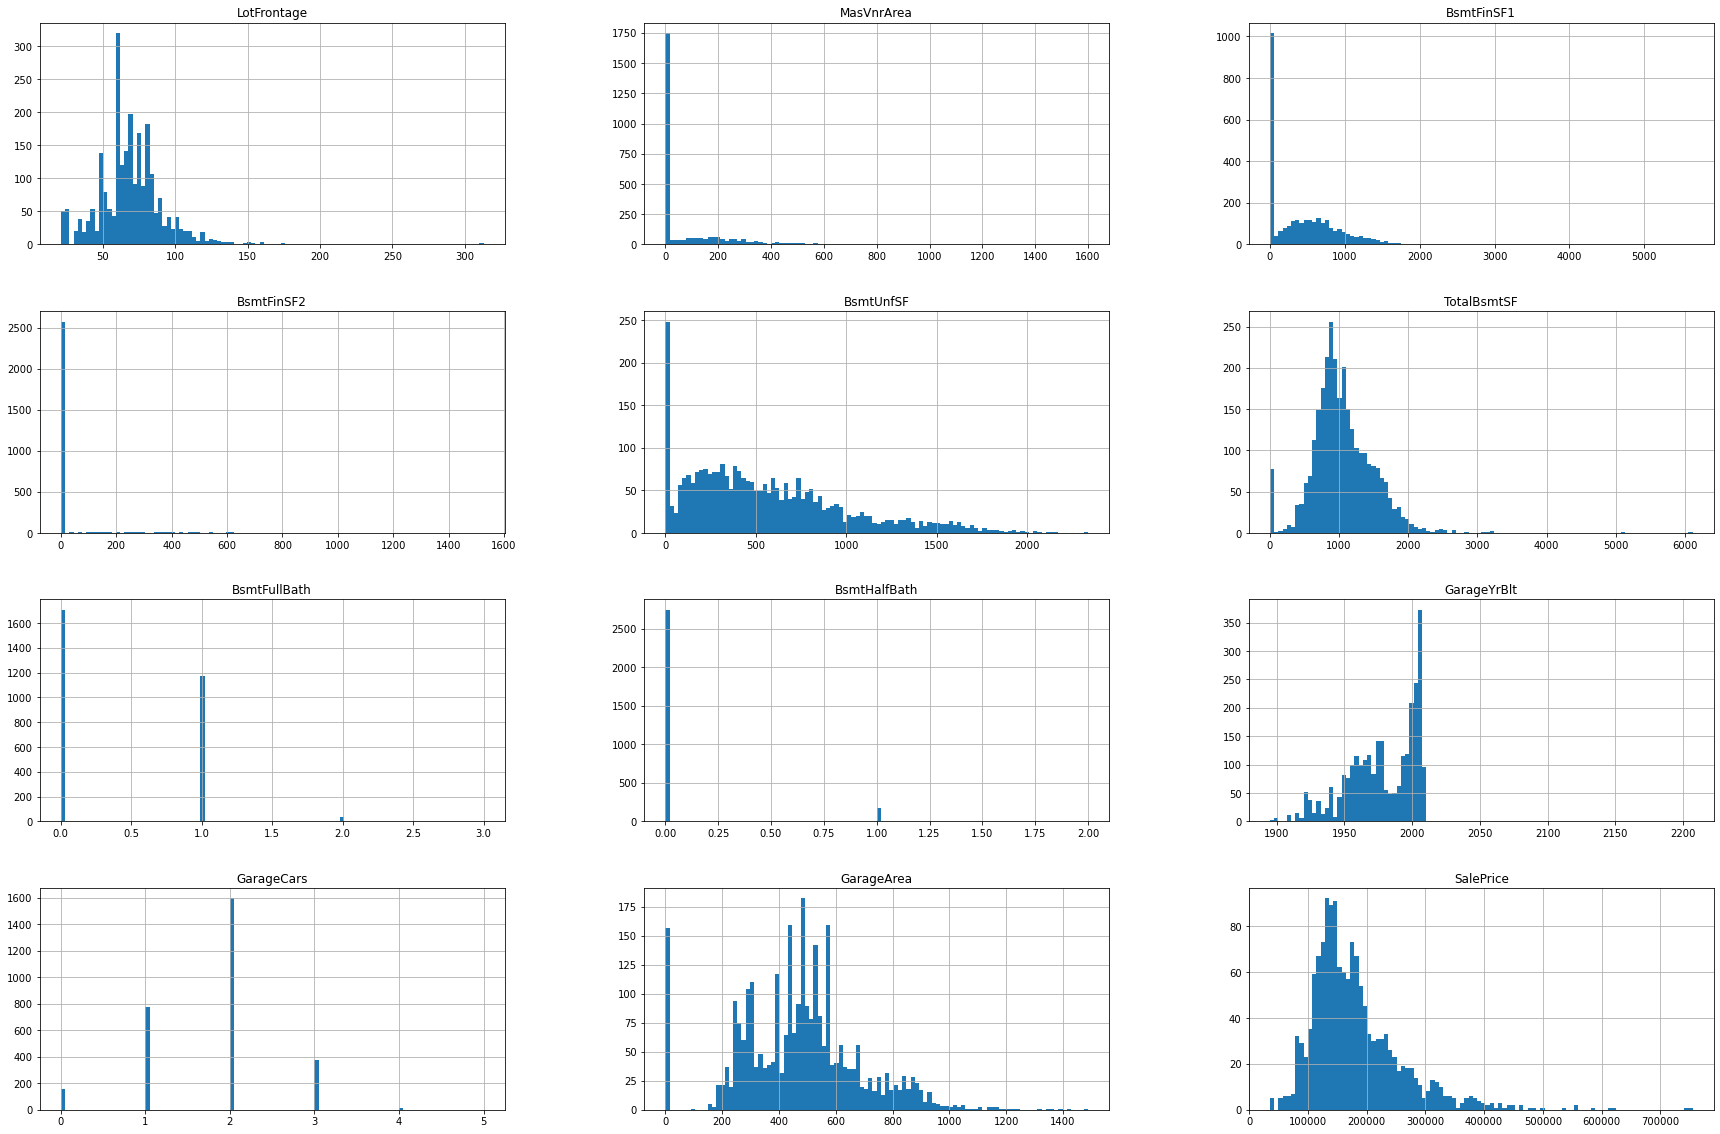

In [36]:
plot_hist_float(df_combine)

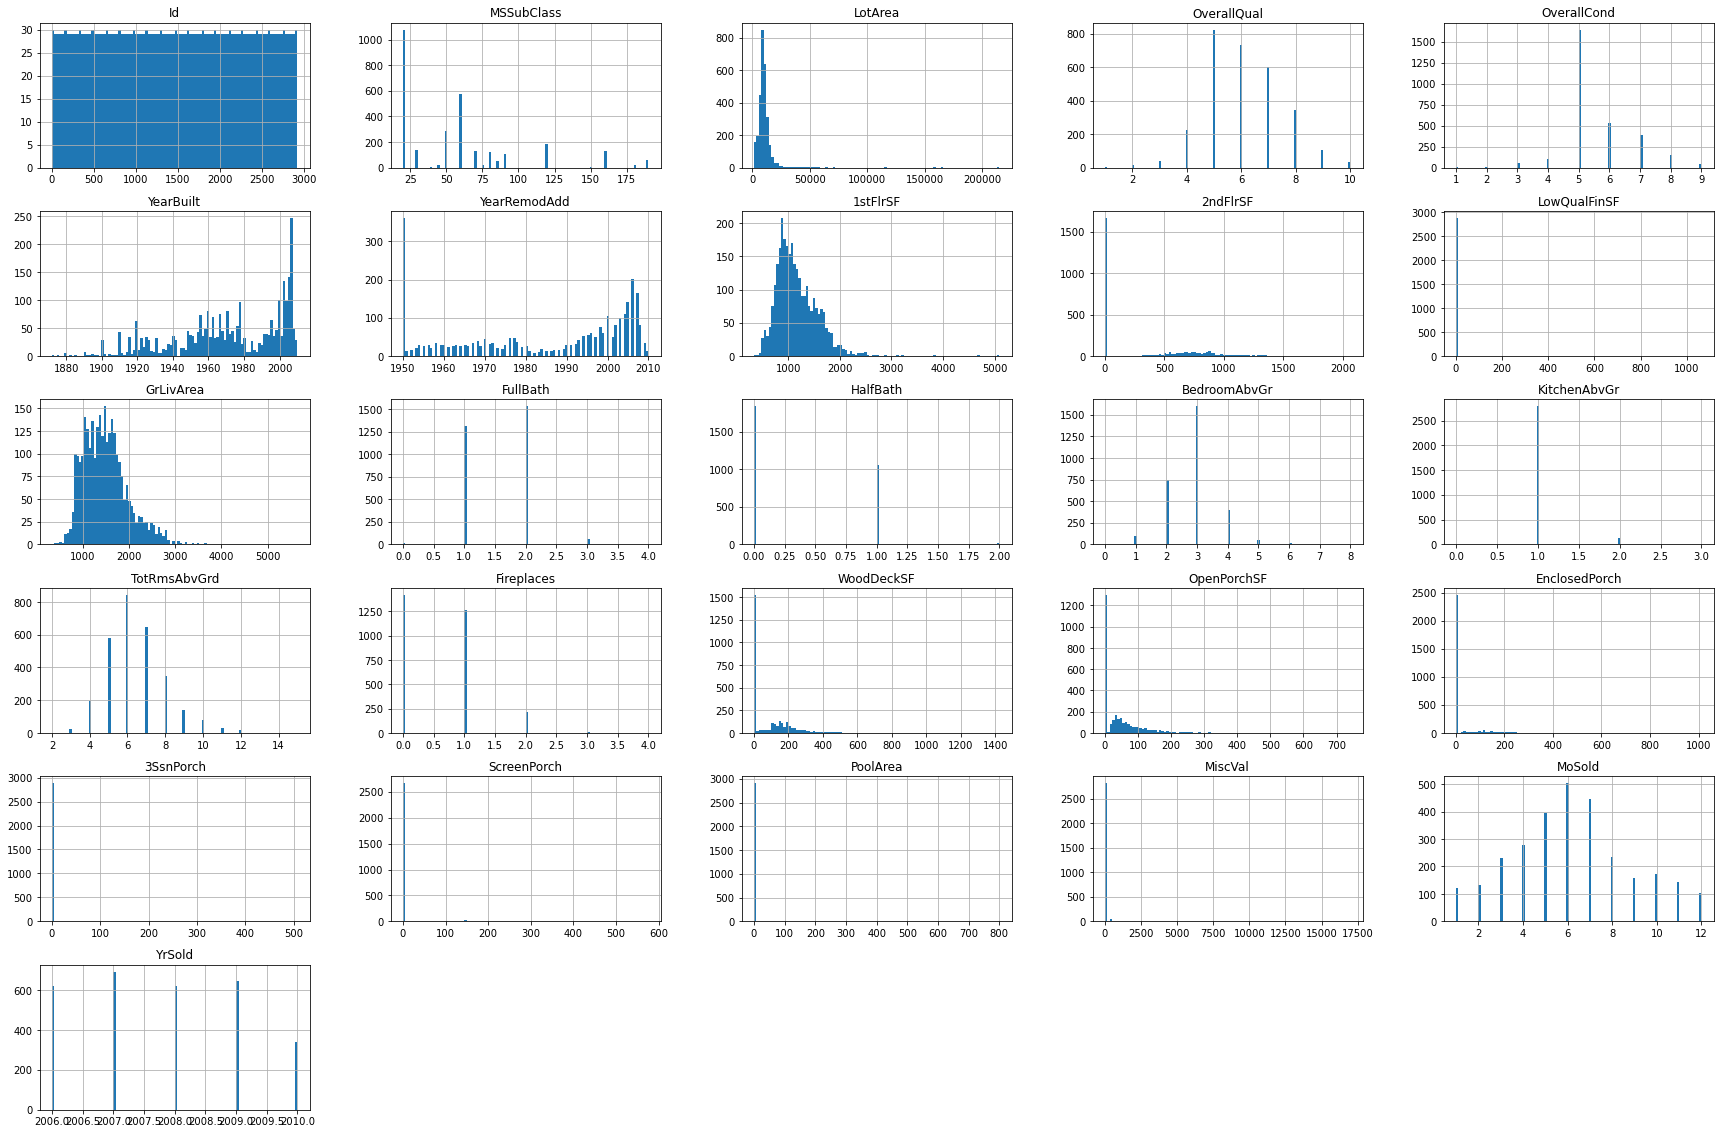

In [37]:
plot_hist_int(df_combine)

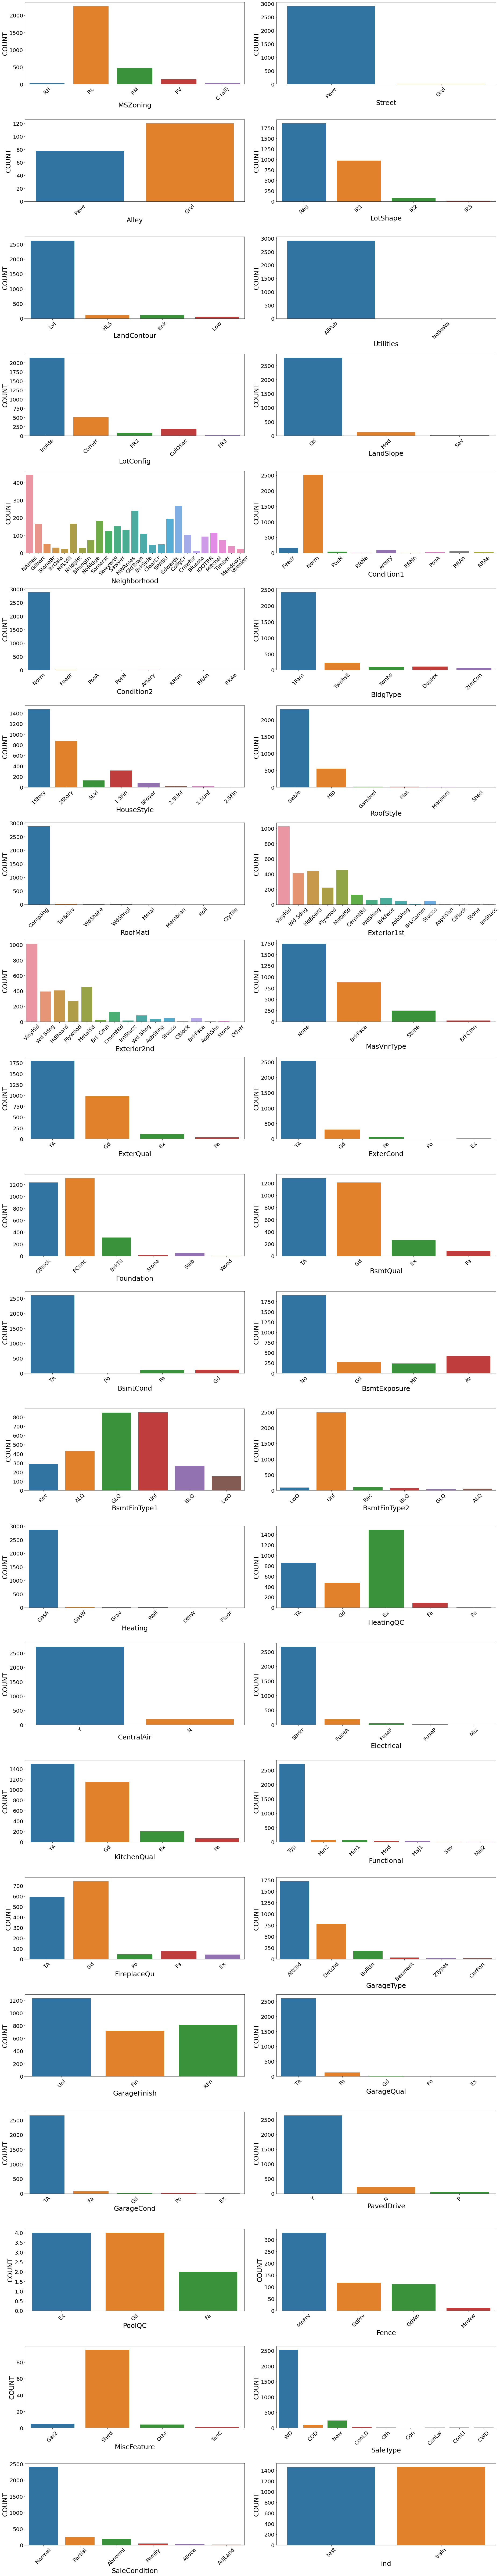

In [38]:
plot_hist_categorical(df_combine)

## Defining pipes

In [39]:
random_forest_imputer_pipe = Pipe([
        fix_subclass,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        one_hot_encoding
        ],
        
        verbose = False,
        impute_method = 'randomforest'
    )

knn_pipe = Pipe([
        fix_subclass,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        one_hot_encoding
        ],
        
        verbose = False,
        impute_method = 'knn'
    )

no_skew_pipe = Pipe([
        fix_subclass,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        one_hot_encoding,
        remove_skew
        ],
        
        verbose = False,
        impute_method = 'knn'
    )

no_skew_scaling = Pipe([
        fix_subclass,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        one_hot_encoding,
        remove_skew,
        scale
        ],
        
        verbose = False,
        impute_method = 'knn',
        scaling_type='RobustScaler'
    )

no_skew_scaling_cosine = Pipe([
        fix_subclass,
        fix_month_sold,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        one_hot_encoding,
        remove_skew,
        scale
        ],
        
        verbose = False,
        impute_method = 'knn',
        scaling_type='RobustScaler'
    )

no_skew_scaling_cosine_more_features = Pipe([
        fix_subclass,
        fix_month_sold,
        impute_categorical_with_na_avail,
        impute_categorical_with_na_not_avail,
        delete_not_needed,
        impute_numeric_cols,
        add_features,
        one_hot_encoding,
        remove_skew,
        scale
        ],
        
        verbose = False,
        impute_method = 'knn',
        scaling_type='RobustScaler'
    )


## Liniear regression

In [40]:
#experiment = LinearExperiment(random_forest_imputer_pipe, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))

In [41]:
#experiment = LinearExperiment(knn_pipe, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))

In [42]:
#experiment = LinearExperiment(no_skew_pipe, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))

In [43]:
#experiment = LinearExperiment(no_skew_scaling, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))

## Decision Tree

In [44]:
#experiment = DecisionTreeExperiment(no_skew_pipe, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

In [45]:
#experiment = DecisionTreeExperiment(no_skew_scaling, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

## Random Forest

In [46]:
#experiment = RandomForestExperiment(no_skew_scaling, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

In [47]:
#experiment = RandomForestExperiment(no_skew_scaling_cosine, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

In [48]:
#experiment = RandomForestExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

## Random Forest with best params

In [49]:
#experiment = RandomForestWithGridSearchExperiment(no_skew_scaling, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

In [50]:
#experiment = RandomForestWithGridSearchExperiment(no_skew_scaling_cosine, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

In [51]:
#experiment = RandomForestWithGridSearchExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0:.4f} STD: {1:.2f}'.format(metric[1], metric[0]))

## Search params for RandomForest

In [52]:
#experiment = RandomForestWithGridSearchExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#p = experiment.search_best_params()
#print(p)

## LightGBM

In [53]:
#experiment = LightGBMExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))
#experiment.to_kaggle()

In [54]:
#experiment = LightGBMExperimentWithParams(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))

## XGB with no params

In [55]:
#experiment = XGBExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))
#experiment.to_kaggle()

In [60]:
#experiment = XGBExperimentWithParams(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
#experiment.transform()
#predicted = experiment.predict()
#metric = experiment.get_metric()
#print('RMSE: {0}'.format(metric))
#experiment.to_kaggle()

## SVR

In [57]:
experiment = LinearSVRExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
experiment.transform()
predicted = experiment.predict()
metric = experiment.get_metric()
print('RMSE: {0}'.format(metric))

RMSE: (8581.982216254195, 188362.4654823888)


In [59]:
experiment = SVRExperiment(no_skew_scaling_cosine_more_features, df_combine, TARGET, TEST_IDS)
experiment.transform()
predicted = experiment.predict()
metric = experiment.get_metric()
print('RMSE: {0}'.format(metric))

RMSE: (9411.500142223122, 77169.22618471886)
Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.2k [00:00<?, ?B/s]
100%|##########| 35.2k/35.2k [00:01<00:00, 20.0kB/s]
